# Mie Scattering and Fog

**Scott Prahl**

** August 2017 **

** version 2 **

## Overview

So clouds are one of the big reasons that Mie scattering is useful.  This notebook covers the basics of log normal distributions and shows a few calculations using miepython.

In [3]:
# execute this cell first
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

#needed for lognormal distribution
from scipy import stats

# if miepython is missing, do `pip install miepython`
import miepython as mp

## Fog data

Fog data from Podzimek, "Droplet Concentration and Size Distribution in Haze and Fog", *Studia geoph. et geod.* **41** (1997).  For our first trick I'll show that the mean droplet size and the most common size (mode) differ.

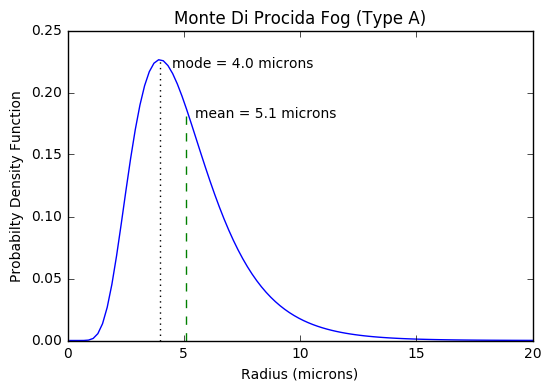

In [9]:
fogtype='Monte Di Procida Fog (Type A)'  # most common fog
r_g=4.69        # in microns
sigma_g = 1.504 # in microns

shape = np.log(sigma_g)
mode = np.exp(np.log(r_g) - np.log(sigma_g)**2)
mean = np.exp(np.log(r_g) + np.log(sigma_g)**2/2)

num=100  #number of droplet sizes to process
r = np.linspace(0.1, 20, num) # values for x-axis

pdf = stats.lognorm.pdf(r, shape, scale=r_g) # probability distribution

plt.plot(r, pdf)
plt.vlines(mode, 0, pdf.max(), linestyle=':', label='Mode')
plt.vlines(mean, 0, stats.lognorm.pdf(mean, shape,  scale=r_g), linestyle='--', color='green', label='Mean')
plt.annotate('mode = 4.0 microns', xy=(4.5,0.22))
plt.annotate('mean = 5.1 microns', xy=(5.5,0.18))

plt.ylim(ymin=0)
plt.xlabel('Radius (microns)')
plt.ylabel('Probabilty Density Function')
plt.title(fogtype)
plt.show()

## Scattering Asymmetry from Fog

So the average cosine of the scattering phase function is often called the scattering asymmetry or just the scattering anisotropy.  The value lies between -1 (completely back scattering) and +1 (total forward scattering).  For these fog values, the scattering is pretty strongly forward scattering.

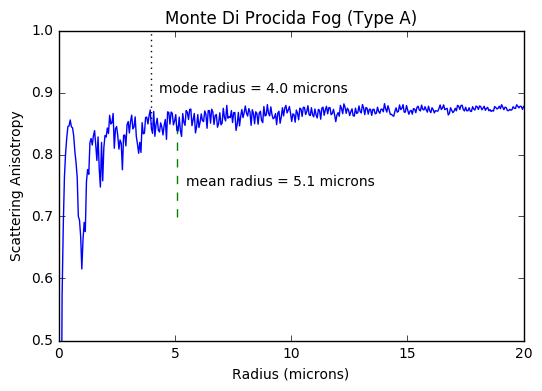

In [20]:
num=400  #number of droplet sizes to process

# distribution of droplet sizes in fog
fogtype='Monte Di Procida Fog (Type A)'
r_g=4.69        # in microns
sigma_g = 1.504 # in microns
shape = np.log(sigma_g)
mode = np.exp(np.log(r_g) - np.log(sigma_g)**2)
mean = np.exp(np.log(r_g) + np.log(sigma_g)**2/2)

r = np.linspace(0.1, 20, num) # values for x-axis
pdf = stats.lognorm.pdf(r, shape, scale=r_g) # probability distribution

# scattering cross section for each droplet size
lambdaa = 0.550 # in microns
m = 1.33
x = 2*np.pi*r/lambdaa

qext, qsca, qback, g = mp.mie(m,x)

plt.plot(r,g)
plt.ylim(0.5,1.0)
plt.xlabel('Radius (microns)')
plt.ylabel('Scattering Anisotropy')
plt.title(fogtype)
plt.vlines(mode, 0.85, 1, linestyle=':', label='Mode')
plt.vlines(mean, 0.7, 0.85, linestyle='--', color='green', label='Mean')
plt.annotate('mode radius = 4.0 microns', xy=(4.3,0.9))
plt.annotate('mean radius = 5.1 microns', xy=(5.5,0.75))

plt.show()

## Scattering as a function of angle

Let's take a closer look at scattering between the mode and mean radius.

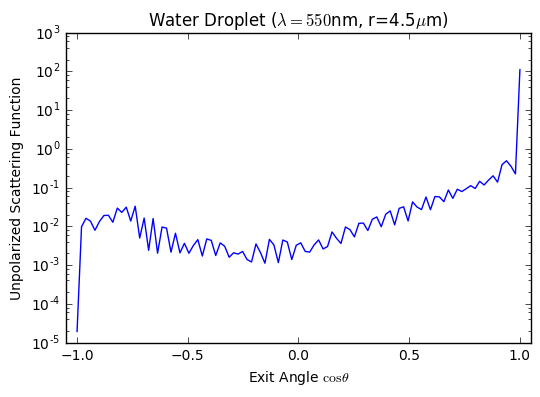

In [23]:
num=100  # number of angles

# scattering cross section for each droplet size
lambdaa = 0.550 # in microns
m = 1.33
r = 4.5         # in microns

x = 2*np.pi*r/lambdaa
mu = np.linspace(-1,1,num)
s1,s2 = mp.mie_S1_S2(m,x,mu)
scatter = 0.5*(abs(s1)**2+abs(s2)**2)

plt.plot(mu,scatter)
plt.yscale('log')
plt.xlim(-1.05,1.05)
#plt.ylim(ymin=0.8)
plt.xlabel(r'Exit Angle $\cos\theta$')
plt.ylabel('Unpolarized Scattering Function')
plt.title(r'Water Droplet ($\lambda=550$nm, r=4.5$\mu$m)')

plt.show()

The graph above does not really do justice to how strongly forward scattering the water droplets are!  Here is a close up of four droplet radii (1,5,10,20) microns.  The most common fog size (5 micron) has a FWHM of 2.5°

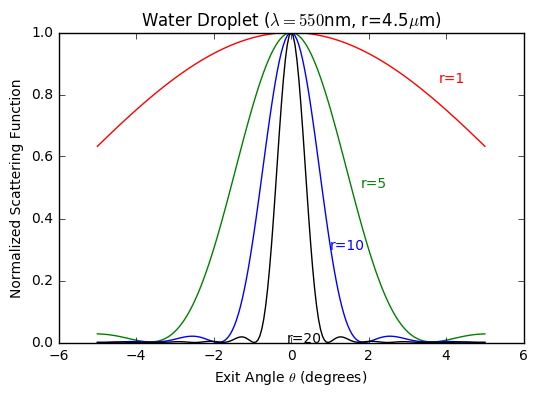

In [24]:
num=100  # number of angles

# scattering cross section for each droplet size
lambdaa = 0.550 
m = 1.33
r = 4.5 
theta = np.linspace(0,5,num)
mu = np.cos(theta*np.pi/180)

r = np.array([1,5,10,20])
kolor = np.array(['red','green','blue','black'])
for i in range(4) :
    x = 2*np.pi*r[i]/lambdaa
    s1,s2 = mp.mie_S1_S2(m,x,mu)
    scatter = 0.5*(abs(s1)**2+abs(s2)**2)
    plt.plot(theta,scatter/scatter[0],color=kolor[i])
    plt.plot(-theta,scatter/scatter[0],color=kolor[i])

plt.annotate('r=%.0f'%r[0], xy=(3.8,0.84), color=kolor[0])
plt.annotate('r=%.0f'%r[1], xy=(1.8,0.5), color=kolor[1])
plt.annotate('r=%.0f'%r[2], xy=(1,0.3), color=kolor[2])
plt.annotate('r=%.0f'%r[3], xy=(-0.1,0.0), color=kolor[3])

#plt.yscale('log')
#plt.ylim(ymin=0.8)
plt.xlabel(r'Exit Angle $\theta$ (degrees)')
plt.ylabel('Normalized Scattering Function')
plt.title(r'Water Droplet ($\lambda=550$nm, r=4.5$\mu$m)')

plt.show()

## Henyey-Greenstein Phase Function

How does the Mie scattering for a 5 micron droplet radius compare with Henyey-Greenstein?

First, need to make sure both scattering functions are normalized to the same overall value.  If we integrate over all $4\pi$ steradians 
$$
\int_{4\pi} S(\theta,\phi)\,d\phi\,\sin\theta d\theta = \int_0^{2\pi}\int_0^\pi S(\theta,\phi)\,d\phi\,\sin\theta d\theta = 2\pi\int_{-1}^1 S(\mu)\,d\mu \approx 2\pi \sum S(\mu_i) \Delta\mu_i = 2\pi \Delta\mu \sum S(\mu_i)
$$
if all the scattering angles are equally spaced in $\cos\theta$.

The integral over all angles for Mie scattering is not 1.  Instead it is $\pi x^2 Q_\mathrm{sca}$ as we see below.

In [26]:
def hg(g,costheta):
    if g==0 :
        return (1/4/np.pi)
    else :
        return (1/4/np.pi)*(1-g**2)/(1+g**2-2*g*costheta)**1.5

num=1000   # increase number of angles to improve integration
r=0.45     # in microns
lambdaa = 0.550 # in microns
m = 1.33

x = 2*np.pi*r/lambdaa
k = 2*np.pi/lambdaa
qext, qsca, qback, g = mp.mie(m,x)

mu = np.linspace(-1,1,num)
s1,s2 = mp.mie_S1_S2(m,x,mu)
miescatter = 0.5*(abs(s1)**2+abs(s2)**2)
hgscatter = hg(g,mu)

delta_mu=mu[1]-mu[0]
total = 2*np.pi*delta_mu*np.sum(miescatter)

print('mie integral= ',total)

total = 2*np.pi*delta_mu*np.sum(hgscatter)
print('hg integral= ', total)

mie integral=  1.01375128258
hg integral=  1.04051434285


Now we can see how bad the approximation is when using the Henyey-Greenstein function.  Here is naive scaling.

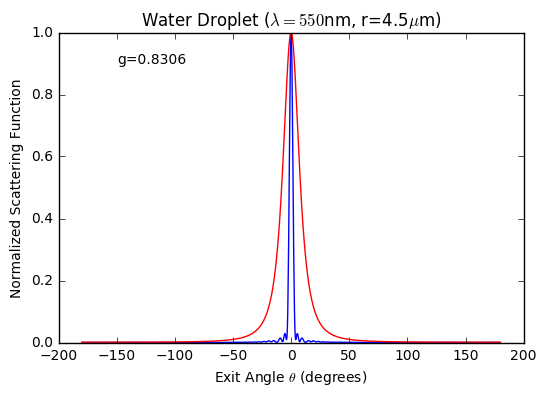

In [29]:
num=500           # number of angles
r=4.5             # microns
lambdaa = 0.550   # microns
m = 1.33

x = 2*np.pi*r/lambdaa
theta = np.linspace(0,180,num)
mu = np.cos(theta*np.pi/180)

s1,s2 = mp.mie_S1_S2(m,x,mu)
miescatter = 0.5*(abs(s1)**2+abs(s2)**2)
hgscatter = hg(g,mu)

plt.plot(theta,miescatter/miescatter[0],color='blue')
plt.plot(-theta,miescatter/miescatter[0],color='blue')
plt.plot(theta,hg(g,mu)/hg(g,1), color='red')
plt.plot(-theta,hg(g,mu)/hg(g,1), color='red')
plt.xlabel(r'Exit Angle $\theta$ (degrees)')
plt.ylabel('Normalized Scattering Function')
plt.title(r'Water Droplet ($\lambda=550$nm, r=4.5$\mu$m)')
plt.annotate('g=%.4f'%g, xy=(-150,0.9))
plt.show()

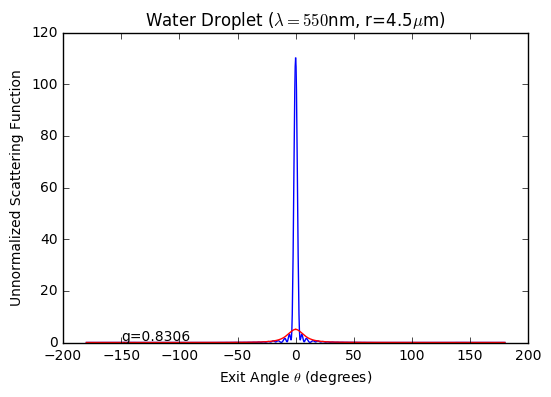

In [30]:
plt.plot(theta,miescatter,color='blue')
plt.plot(-theta,miescatter,color='blue')
plt.plot(theta,hg(g,mu), color='red')
plt.plot(-theta,hg(g,mu), color='red')
plt.xlabel(r'Exit Angle $\theta$ (degrees)')
plt.ylabel('Unnormalized Scattering Function')
plt.title(r'Water Droplet ($\lambda=550$nm, r=4.5$\mu$m)')
plt.annotate('g=%.4f'%g, xy=(-150,0.9))
plt.show()

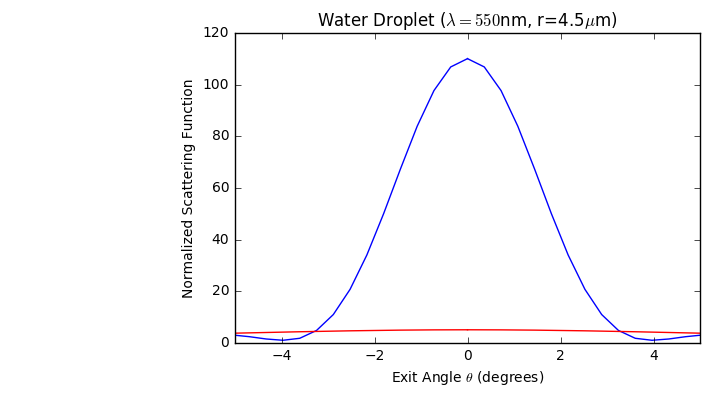

In [31]:
plt.plot(theta,miescatter,color='blue')
plt.plot(-theta,miescatter,color='blue')
plt.plot(theta,hg(g,mu), color='red')
plt.plot(-theta,hg(g,mu), color='red')
plt.xlabel(r'Exit Angle $\theta$ (degrees)')
plt.ylabel('Normalized Scattering Function')
plt.title(r'Water Droplet ($\lambda=550$nm, r=4.5$\mu$m)')
plt.annotate('g=%.4f'%g, xy=(-150,0.9))
plt.xlim([-5,5])
plt.show()

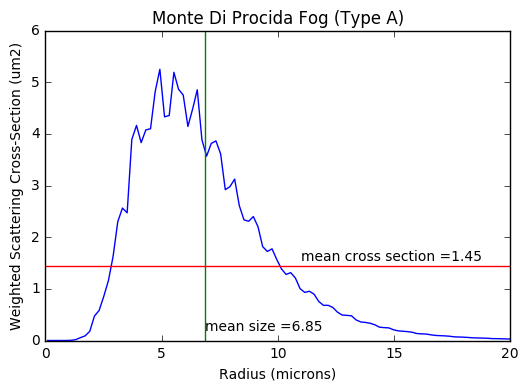

In [41]:
num=100

# distribution of droplet sizes in fog
r = np.linspace(0.1, 20, num) # values for x-axis
pdf = stats.lognorm.pdf(r, shape, scale=r_g) # probability distribution

# scattering cross section for each droplet size
lambdaa = 0.550 
m = 1.33
x = 2*np.pi*r/lambdaa

qext, qsca, qback, g = mp.mie(m,x)
cross_section = qsca * np.pi*r**2*(1-g)

# weighted average of the cross_sections
mean_cross = 0
mean_r = 0
for i in range(num) :
    mean_cross += cross_section[i] * pdf[i]
    mean_r += cross_section[i] * pdf[i] * r[i]
mean_r /= mean_cross
mean_cross /= num

plt.plot(r,cross_section*pdf)
#plt.plot(r,pdf*100)

plt.plot((mean_r, mean_r),(0, 40))
plt.plot((0, 20),(mean_cross,mean_cross))

plt.ylim(0,6)
plt.xlabel('Radius (microns)')
plt.ylabel('Weighted Scattering Cross-Section (um2)')
plt.annotate('mean cross section =%.2f'%mean_cross, xy=(11,mean_cross+0.1))
plt.annotate('mean size =%.2f'%mean_r, xy=(mean_r,0.2))

plt.title(fogtype)
plt.show()